In [135]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pyckmeans import CKmeans
from pyckmeans import MultiCKMeans
import ClusterEnsembles as CE
from sklearn.metrics import jaccard_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import calinski_harabasz_score

In [136]:


df = pd.read_csv('seeds_dataset.txt', sep= '\t', header= None,
                 names=['area','perimeter','compactness','lengthOfKernel','widthOfKernel','asymmetryCoefficient',
                        'lengthOfKernelGroove','seedType'])
df.head()

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [137]:
# define the actual data
seed_data = df.drop(columns=['seedType'])
def define_species(df, target_column):
    species = ["cluster_" + str(val) for val in target_column]
    df['Species'] = species
define_species(df, np.array(df['seedType']))

<AxesSubplot: >

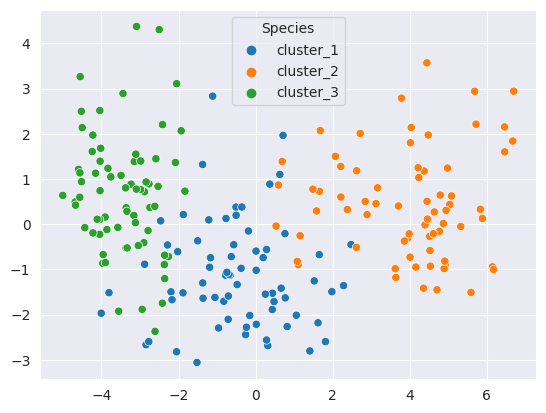

In [138]:
#  transform the actual data and display it

X_reduced = PCA(n_components=2).fit_transform(seed_data)
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['Species'])

In [139]:
# KMeans from sklearn to cluster the iris data with k = [2, 3, 4, 5]
KMeans_k2 = KMeans(n_clusters=2)
k2_model = KMeans_k2.fit(seed_data)

KMeans_k3 = KMeans(n_clusters=3)
k3_model = KMeans_k3.fit(seed_data)

KMeans_k4 = KMeans(n_clusters=4)
k4_model = KMeans_k4.fit(seed_data)

KMeans_k5 = KMeans(n_clusters=5)
k5_model = KMeans_k5.fit(seed_data)

<AxesSubplot: >

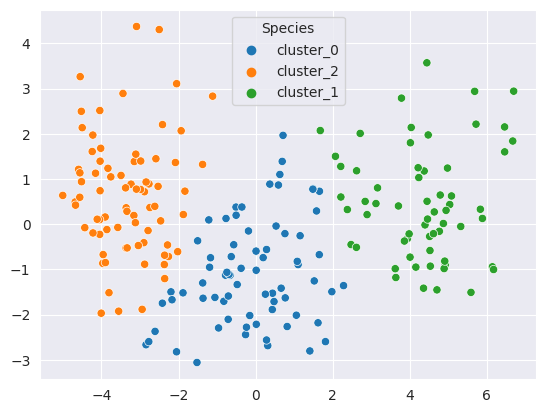

In [140]:
# display the result of using KMeans with k = 3
define_species(df, k3_model.labels_)
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['Species'])

In [141]:
#Compare the actual Data with the result of using KMeans with k = 3
print("Jacard Score = ", jaccard_score(np.array(df['seedType']), k3_model.labels_, average='weighted'))
print("DBI = ", davies_bouldin_score(X_reduced, k3_model.labels_))
print("silhouette_score = " , silhouette_score(X_reduced, k3_model.labels_))
# to see the different with the actual data
pd.crosstab(df['seedType'], k3_model.labels_)

Jacard Score =  0.0025641025641025645
DBI =  0.7369303836699436
silhouette_score =  0.4802142699427175


col_0,0,1,2
seedType,,,
1,60,1,9
2,10,60,0
3,2,0,68


<AxesSubplot: >

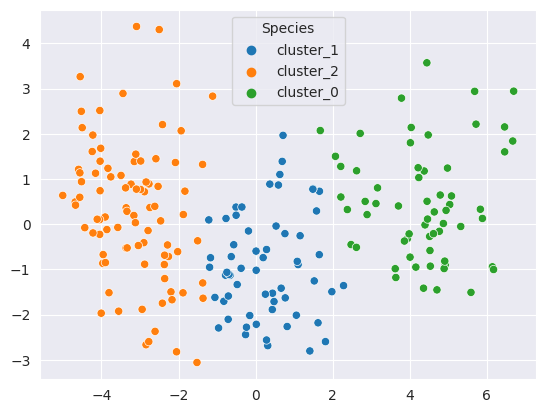

In [142]:
# Ensemble Clustering using CKmeans with a single k = 3
ckm = CKmeans(k=3, n_rep=100)
ckm.fit(seed_data)
ckm_res = ckm.predict(seed_data)
define_species(df, ckm_res.cl)
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['Species'])

In [143]:
# the different between the CKmeans and the actual data
pd.crosstab(df['seedType'], ckm_res.cl)

col_0,0,1,2
seedType,,,
1,1,50,19
2,60,10,0
3,0,0,70


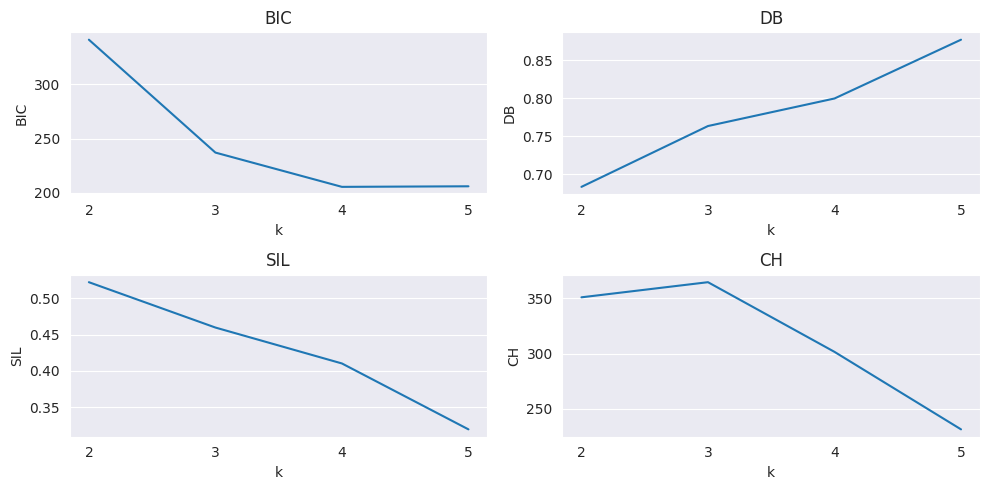

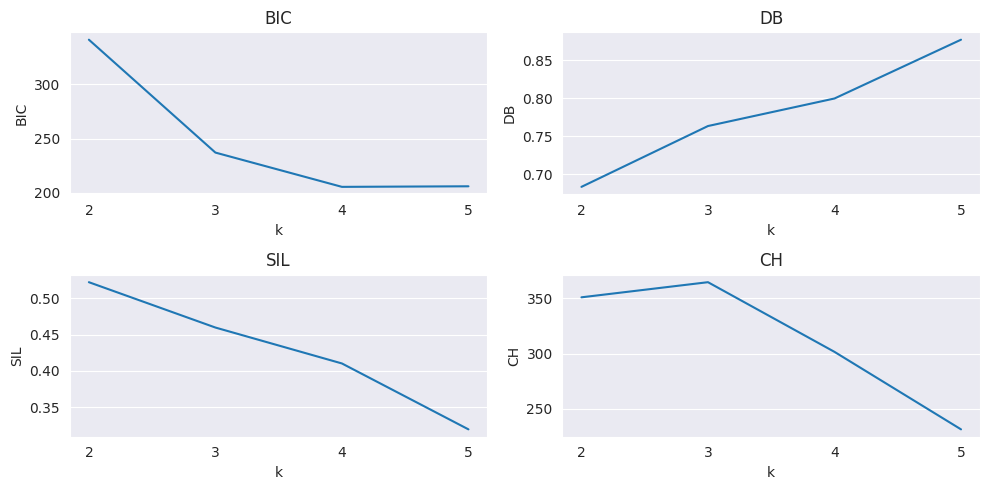

In [144]:
# Ensemble Clustering using CKmeans with a multi k = [2, 3, 4, 5]
mckm = MultiCKMeans(k=[2, 3, 4, 5], n_rep=100)
mckm.fit(seed_data)
mckm_res = mckm.predict(seed_data)
df_species = []
for i in range(4):
    define_species(df, mckm_res.ckmeans_results[i].cl)
    df_species.append(df['Species'])

# plot clustering metrics against k
# BIC, DB: lower is better
# SIL, CH: higher is better
mckm_res.plot_metrics(figsize=(10,5))

<AxesSubplot: >

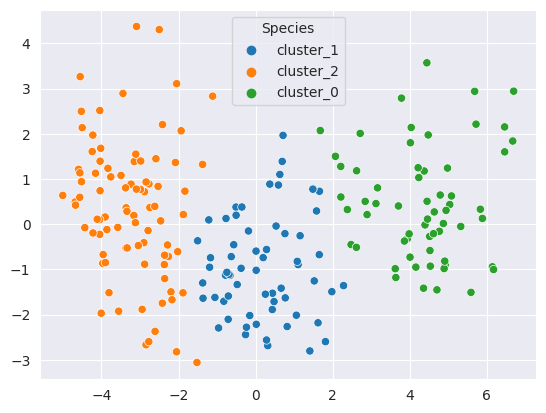

In [145]:
# display the result for k = 3
df['Species'] = df_species[1]
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['Species'])

In [149]:
'''
Ensemble Clustering using algo_name ['cspa', 'mcla', 'hbgf', 'nmf'] from ClusterEnsembles
Input = results of Kmeans models from earlier with k = [2, 3, 4, 5]
compare the result of algo_name with the actual data and display the difference for k = 3
'''
def useEnsembleClustering(algo_name, best_k, ensemble_input, k_list):
    print(f'The result of {algo_name}')
    scores = []
    for k in k_list:
        label_pred = CE.cluster_ensembles(ensemble_input, nclass=k, solver=algo_name)
        if k == best_k:
            print(pd.crosstab(df['seedType'], label_pred))
        scores_for_k = []
        scores_for_k.append(jaccard_score(np.array(df['seedType']), label_pred, average='weighted'))
        scores_for_k.append(davies_bouldin_score(X_reduced, label_pred))
        scores_for_k.append(silhouette_score(X_reduced, label_pred))
        scores_for_k.append(normalized_mutual_info_score(np.array(df['seedType']), label_pred, average_method='geometric'))
        scores_for_k.append(adjusted_rand_score(np.array(df['seedType']), label_pred))
        scores_for_k.append(fowlkes_mallows_score(np.array(df['seedType']), label_pred))
        scores_for_k.append(calinski_harabasz_score(X_reduced, label_pred))
        scores.append(scores_for_k)
    print("jaccard_score, davies_bouldin_score, silhouette_score, normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score, calinski_harabasz_score")
    for element in scores:
        print(element)

In [150]:
ensemble_input = np.array([k2_model.labels_, k3_model.labels_, k4_model.labels_, k5_model.labels_])
useEnsembleClustering('cspa', 3, ensemble_input, [2, 3, 4, 5])

The result of cspa
col_0      0   1   2
seedType            
1          5  60   5
2         67   3   0
3          0   6  64
jaccard_score, davies_bouldin_score, silhouette_score, normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score, calinski_harabasz_score
[0.07565011820330969, 0.7498731401161138, 0.47551217182675826, 0.5022020011711213, 0.42962884677280944, 0.6699404784922067, 300.416547436232]
[0.25316455696202533, 0.7358101376889068, 0.4622490247406232, 0.702970325077663, 0.7503924708684339, 0.8328158599727407, 354.6486881353163]
[0.06638250848527903, 0.9296638759322129, 0.345610667059644, 0.5777646495735802, 0.5025803940611173, 0.6498940780805773, 294.2482317960989]
[0.12210572302315421, 1.0159202634007822, 0.3187021213934172, 0.587499562673845, 0.45351312987934705, 0.6080541271837426, 271.3617385404555]


In [151]:
useEnsembleClustering('mcla', 3, ensemble_input, [2, 3, 4, 5])

The result of mcla
col_0      0   1   2
seedType            
1         11  55   4
2          0   8  62
3         69   1   0
jaccard_score, davies_bouldin_score, silhouette_score, normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score, calinski_harabasz_score
[0.10952380952380952, 0.7105459030642554, 0.5053276154747247, 0.5445933933529772, 0.45397186216883745, 0.6866188111690155, 341.2420543026178]
[0.5113467898278025, 0.748608214501608, 0.45770121640864186, 0.6710398092431494, 0.6974939970383423, 0.7978963476548562, 361.45327474906435]
[0.12245451025938832, 0.9017834929539592, 0.38192607759122915, 0.6477040815972179, 0.6322026089807709, 0.7448315986829216, 315.55132474549566]
[0.01574074074074074, 1.2617513479719578, 0.24067649697058716, 0.603025886531273, 0.5687671997998569, 0.6975031590909331, 232.91015116696067]


In [152]:
useEnsembleClustering('hbgf', 3, ensemble_input, [2, 3, 4, 5])

The result of hbgf
col_0      0   1   2
seedType            
1          4  61   5
2         65   5   0
3          0   5  65
jaccard_score, davies_bouldin_score, silhouette_score, normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score, calinski_harabasz_score
[0.08095238095238096, 0.7421027224453731, 0.4787739054287794, 0.5296618673800626, 0.4409860953635489, 0.6768902036056984, 308.29087585499235]
[0.25416666666666665, 0.751563572026179, 0.45627934231117045, 0.7006054766565244, 0.7487266294041764, 0.8316886363050673, 350.99104567194735]
[0.06602564102564103, 0.9125644478550751, 0.3446282318621987, 0.5807775703024218, 0.4845943968226289, 0.6367951660605763, 301.23289193010794]
[0.009063609063609063, 1.0370794105043168, 0.3066052189956905, 0.5924680512997923, 0.4588550767641467, 0.6122000038579737, 264.395448074955]


In [153]:
useEnsembleClustering('nmf', 3, ensemble_input, [2, 3, 4, 5])

The result of nmf
col_0      0   1   2
seedType            
1         60   1   9
2         10  60   0
3          2   0  68
jaccard_score, davies_bouldin_score, silhouette_score, normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score, calinski_harabasz_score
[0.13002364066193853, 0.681879340859199, 0.5235443824136065, 0.5522450325042095, 0.46832262167598226, 0.7000267531667786, 357.80610604032796]
[0.0025641025641025645, 0.7369303836699436, 0.4802142699427175, 0.6949265763820529, 0.7166198557361053, 0.8106151670655933, 387.01433357417494]
[0.6068077864057015, 0.9202956906839941, 0.3938057756399479, 0.6614327833566888, 0.6467842749483, 0.7555993040992205, 321.3673409795718]
[0.6478074943828368, 1.0007949531390028, 0.3356776512165804, 0.6145835468541724, 0.5356404707782905, 0.6717385311961802, 296.2740593158003]
